## Loading Data

In [2]:
import pandas as pd
site_df = pd.read_csv('data/abcd_y_lt.csv').iloc[:,[0,2,7]]
testdata = pd.read_csv('data/test.csv')
testdata = testdata[testdata.columns[~testdata.columns.str.startswith("cbcl")]]
traindata = pd.read_csv('data/train.csv')
traindata = traindata[traindata.columns[~traindata.columns.str.startswith("cbcl")]]
lostcolumns= ["interview_date","site","src_subject_id","y_t", "y_{t+1}", "eventname","race_ethnicity","urban"]
site_df['interview_date'] = pd.to_datetime(site_df['interview_date'], errors = 'coerce')
traindata['interview_date'] = pd.to_datetime(traindata['interview_date'], errors = 'coerce')
testdata['interview_date'] = pd.to_datetime(testdata['interview_date'], errors = 'coerce')
site_df['site_id_l'] = site_df['site_id_l'].str[4:].astype(int)
subject_date_site_mapping = (
    site_df.groupby('src_subject_id')
    .apply(lambda x: dict(zip(x['interview_date'], x['site_id_l'])))
    .to_dict()
)
def get_site(row):
    subject_id = row['src_subject_id']
    interview_date = row['interview_date']
    return subject_date_site_mapping.get(subject_id, {}).get(interview_date, None)

df_urban = pd.read_csv("data/led_l_urban.csv")
traindata['site'] = traindata.apply(get_site, axis=1)
traindata.insert(1, 'site', traindata.pop('site'))
traindata = traindata.merge(
    df_urban[['src_subject_id', 'reshist_addr1_urban_area']],
    on='src_subject_id',
    how='left'  
)
traindata.insert(1, 'urban', traindata.pop('reshist_addr1_urban_area'))


testdata['site'] = traindata.apply(get_site, axis=1)
testdata.insert(1, 'site', testdata.pop('site'))  
testdata = testdata.merge(
    df_urban[['src_subject_id', 'reshist_addr1_urban_area']],
    on='src_subject_id',
    how='left' 
)
testdata.insert(1, 'urban', testdata.pop('reshist_addr1_urban_area'))  

testdata = testdata.apply(pd.to_numeric,errors='coerce')

traindata = traindata.apply(pd.to_numeric,errors='coerce')

data = pd.concat([traindata, testdata], axis=0, ignore_index=True)



if data.isnull().any().any():
    data = data.fillna(0)

data['white'] = (data['race_ethnicity'] == 1).astype(int)
data['black'] = (data['race_ethnicity'] == 2).astype(int)
data['hispano'] = (data['race_ethnicity'] == 3).astype(int)
data['asian'] = (data['race_ethnicity'] == 4).astype(int)
data['others'] = (data['race_ethnicity'] == 5).astype(int)



data_mapping = {
    site: group_df for site, group_df in data.groupby('site') if site != 22
}
maxx=0
people_num =[]
for i in data_mapping:
    people_num.append(len(data_mapping[i]))
    if len(data_mapping[i])>maxx:
        maxx=len(data_mapping[i])
        largest_site_index=i

largest_site_index = [16]
choose_tuning=sorted(range(len(people_num)), key=lambda x: people_num[x], reverse=True)[1:3]
choose_tuning=[x + 1 for x in choose_tuning]
hatdata = pd.concat(
[data_mapping[testiter] for testiter in data_mapping if testiter in choose_tuning], 
axis=0, 
ignore_index=True
)


traindata = pd.concat(
[data_mapping[testiter] for testiter in data_mapping if testiter in largest_site_index], 
axis=0, 
ignore_index=True
)


testdata = pd.concat(
[data_mapping[testiter] for testiter in data_mapping if testiter not in largest_site_index and testiter not in choose_tuning], 
axis=0, 
ignore_index=True
)
data_train = traindata
data_test =testdata



X_train = data_train.drop(columns=lostcolumns)
feature_names = X_train.columns

top_vars = [x for x in data.columns if x not in lostcolumns]

X_train = X_train[top_vars]

y_train = data_train["y_{t+1}"]
input_dim = X_train.shape[1]
X_train = X_train.values
filtered_list = [num for num in range(1, 22) if num not in largest_site_index and num not in choose_tuning]


white_proportion = []
hispano_proportion = []
black_proportion = []
asian_proportion = []
other_proportion = []
for i in filtered_list:
    
    white_proportion.append(round((data_mapping[i]['race_ethnicity'] == 1).mean(),2))
    hispano_proportion.append((data_mapping[i]['race_ethnicity'] == 3).mean())
    black_proportion.append((data_mapping[i]['race_ethnicity'] == 2).mean())
    asian_proportion.append((data_mapping[i]['race_ethnicity'] == 4).mean())
    other_proportion.append((data_mapping[i]['race_ethnicity'] == 5).mean())


    

/var/folders/47/91sqyf453hs814g86jzgnwdh0000gn/T/ipykernel_57188/1239623653.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: dict(zip(x['interview_date'], x['site_id_l'])))


In [ ]:
from models import (
    train_and_eval_traditional,
    train_and_eval_regularization,
    train_and_eval_dro_multiple
)

print("TRA")
trad_model, trad_auc, trad_probs, trad_auc_4, trad_probs_4 = train_and_eval_traditional(
    X_train, y_train, data, top_vars, filtered_list
)
print("REG")
reg_model, reg_auc, reg_probs, reg_auc_4, reg_probs_4, reg_white, reg_white_4 = train_and_eval_regularization(
    X_train, y_train, hatdata, top_vars, data, filtered_list
)
print("DRO")
dro_models, dro_auc, dro_probs, dro_auc_4, dro_probs_4, dro_white, dro_white_4, dro_best_params = train_and_eval_dro_multiple(
    n_runs=2,
    X_train=X_train,
    y_train=y_train,
    hatdata=hatdata,
    top_vars=top_vars,
    data=data,
    filtered_list=filtered_list
)


TRA
REG
0.7368258792779472
0.7368258792779472
0.7832364432014025
0.7832364432014025
0.7832364432014025
0.7832364432014025
0.7832364432014025
0.7832364432014025
0.7832364432014025
DRO
0
0.7793312749902156
0.7878190794216803
0.7878190794216803
0.7878190794216803
0.7878190794216803
0.7878190794216803
0.7878190794216803
0.7878190794216803
0.7878190794216803
0.7878190794216803
0.7878190794216803
0.7878190794216803
0.7878190794216803
0.7878190794216803
0.7878190794216803
0.7878190794216803
0.7878190794216803
0.7878190794216803
1
0.5645099457338969
0.7773705086274177
0.7773705086274177
0.7773705086274177
0.7773705086274177
0.7773705086274177
0.7832573852023592
0.7832573852023592
0.7857495977533696
0.7857495977533696
0.7857495977533696
0.7857495977533696
0.7857495977533696
0.7857495977533696
0.7857495977533696
0.7875769303832958
0.7875769303832958
0.7875769303832958


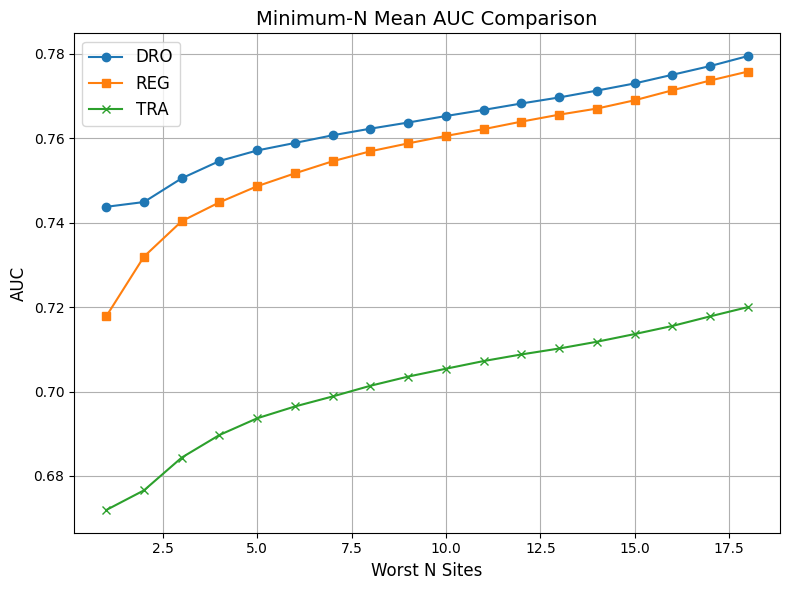

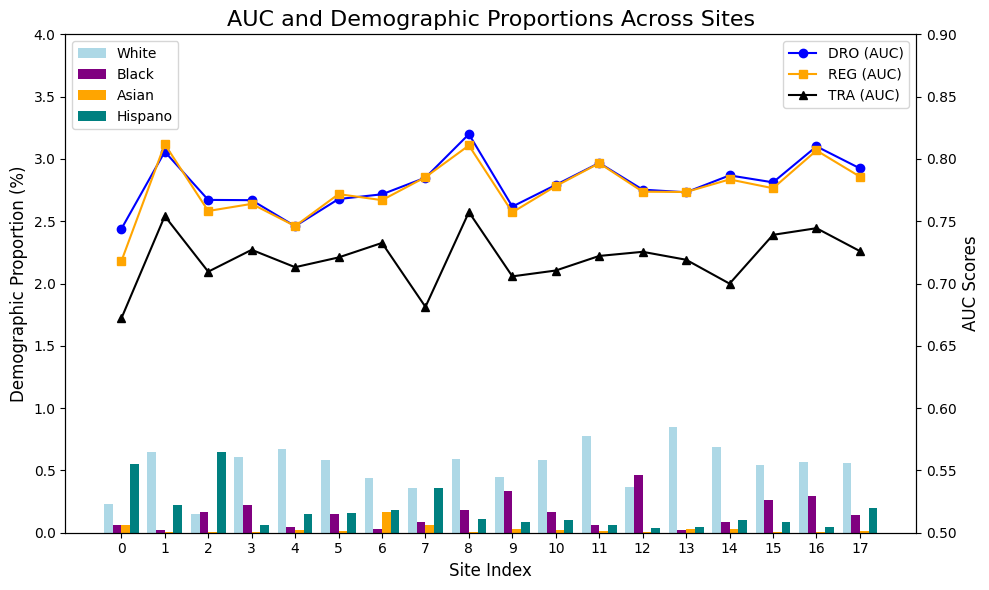

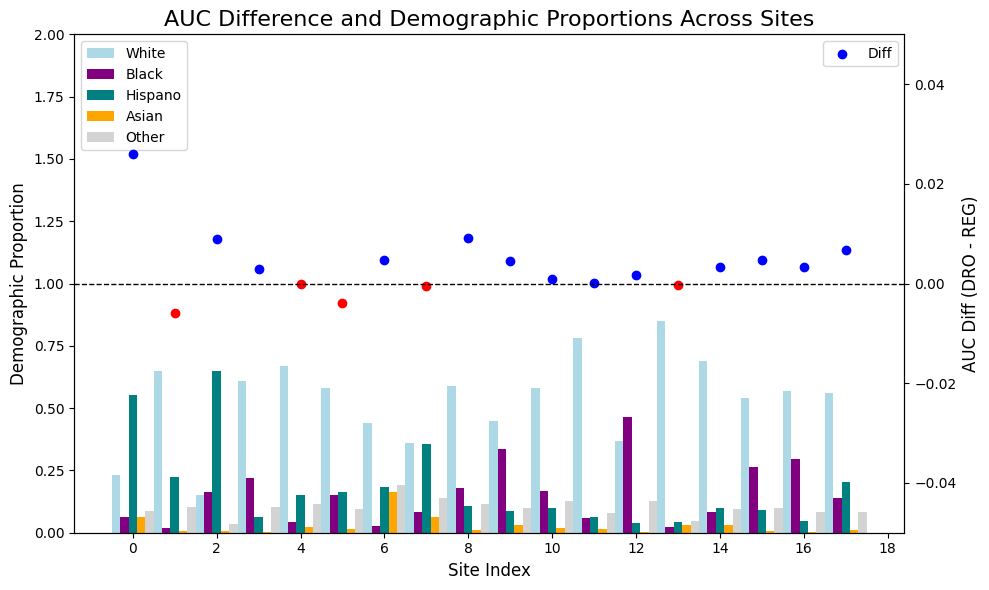


Mean's Comparison Results:
              Comparison    t_stat   p_value
0  Regularization vs DRO -2.295339  0.034708


,Comparison,t_stat,p_value
0,Regularization vs DRO,-2.295339,0.034708


In [4]:
from src.utils_plot import plot_auc_demographic_comparison
hist_dro = dro_auc
x_values = list(range(0, len(hist_dro) ))
bar_width = 0.2
color = ['lightblue', 'purple', 'teal', 'orange', 'lightgray']
plot_auc_demographic_comparison(
    trad_auc,
    reg_auc,
    dro_auc,
    reg_white,
    dro_white,
    white_proportion,
    black_proportion,
    asian_proportion,
    hispano_proportion,
    other_proportion,
    filtered_list,
    white_only=False  
)


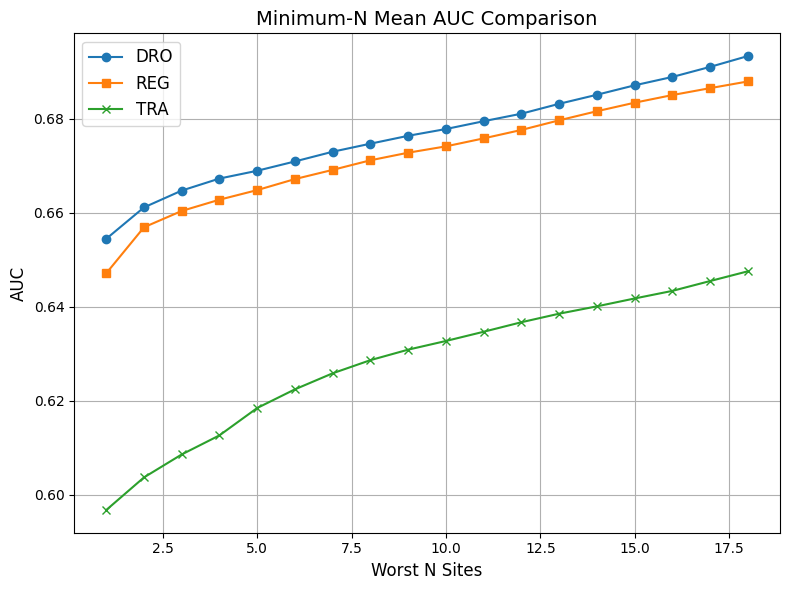

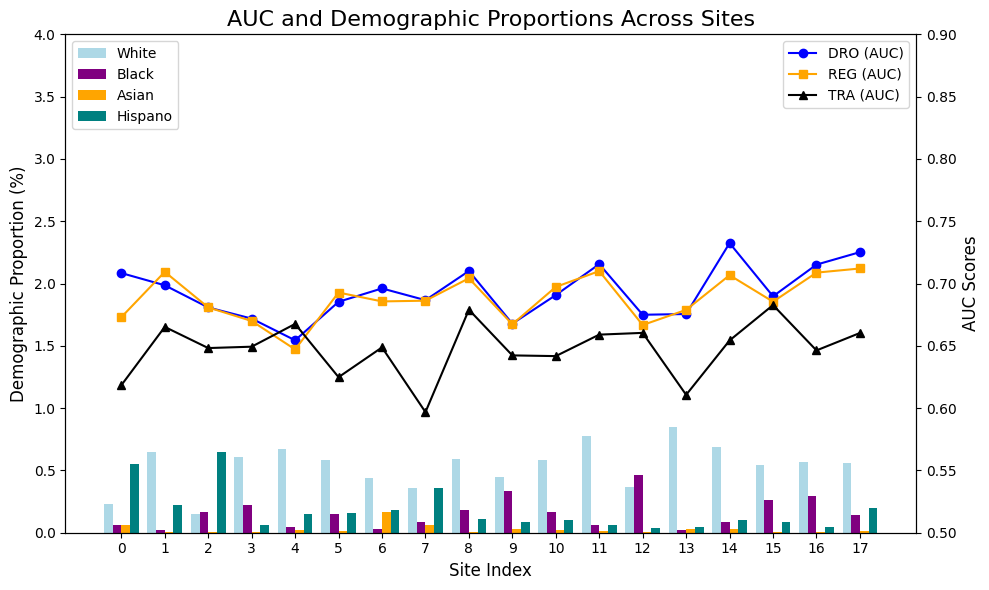

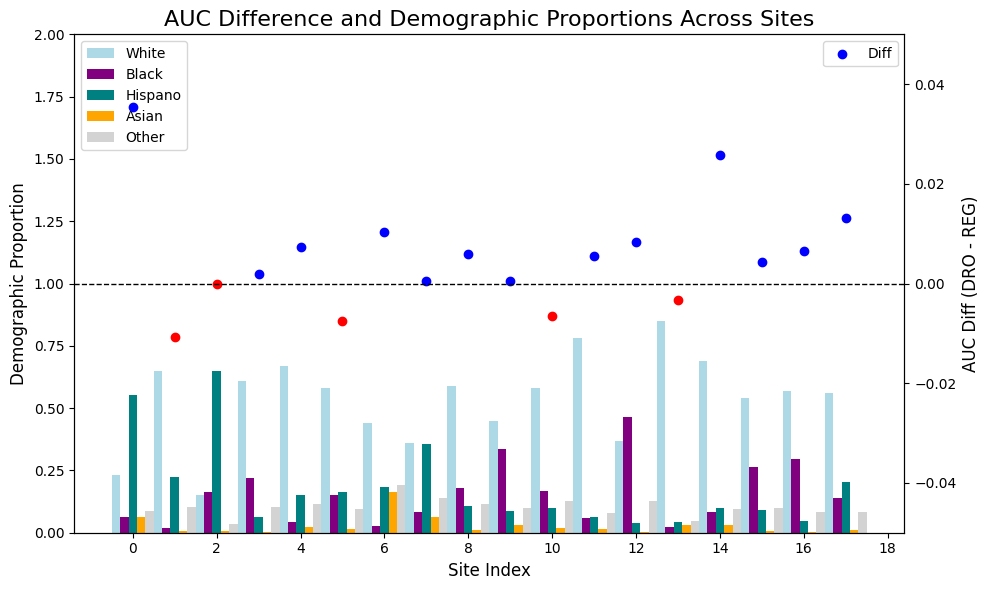


Mean's Comparison Results:
              Comparison    t_stat   p_value
0  Regularization vs DRO -2.036963  0.057535


,Comparison,t_stat,p_value
0,Regularization vs DRO,-2.036963,0.057535


In [6]:
plot_auc_demographic_comparison(
    trad_auc_4,
    reg_auc_4,
    dro_auc_4,
    reg_white_4,
    dro_white_4,
    white_proportion,
    black_proportion,
    asian_proportion,
    hispano_proportion,
    other_proportion,
    filtered_list,
    white_only=False  
)

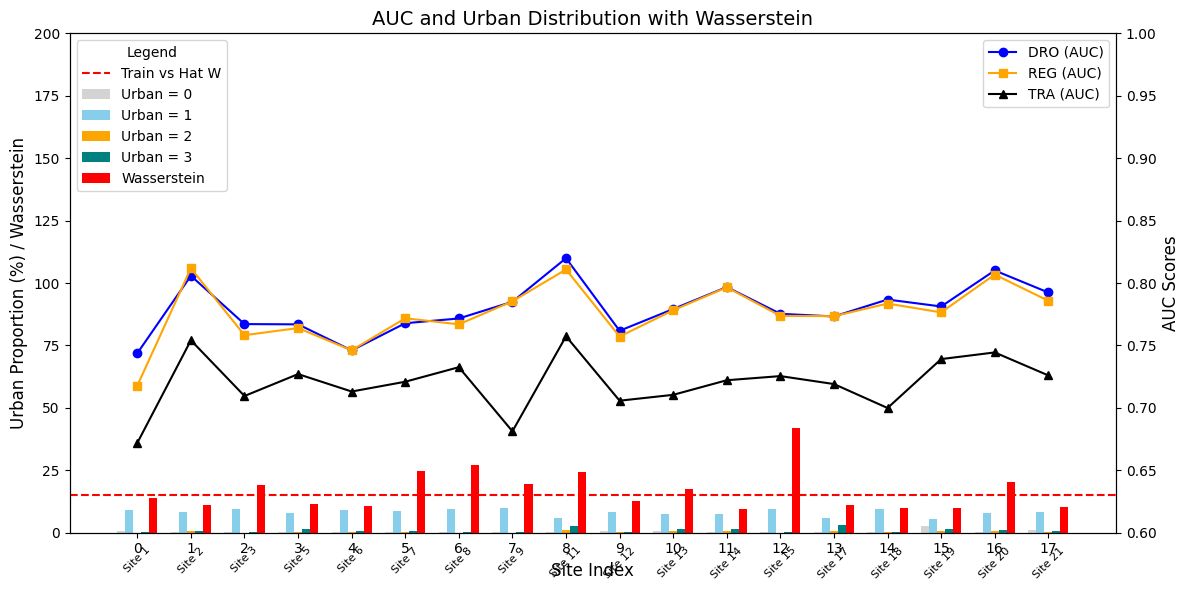

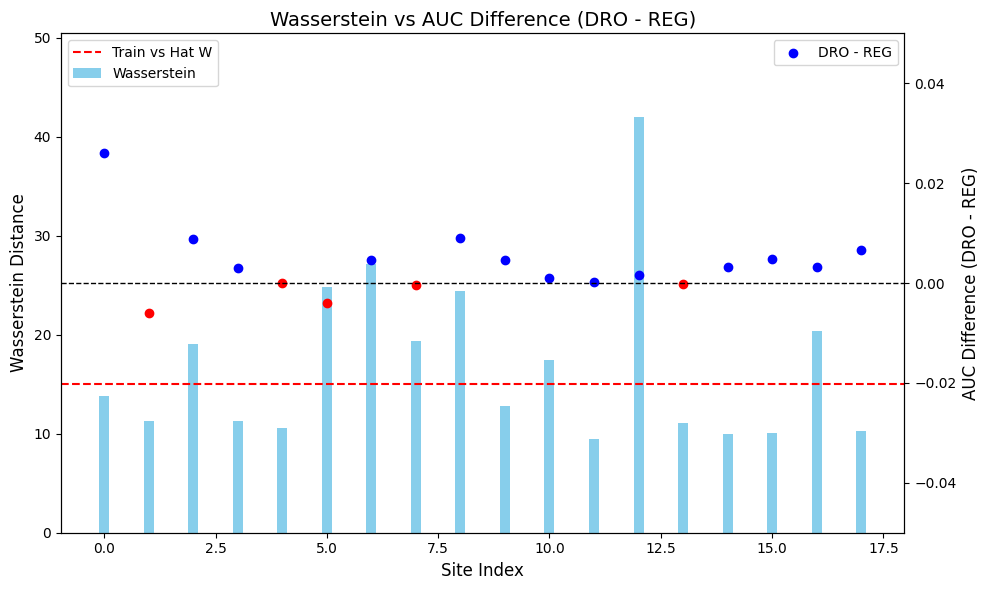


T-test Comparison Results:
                      Comparison     t_stat       p_value
0  Traditional vs Regularization -13.044695  2.777649e-10
1             Traditional vs DRO -14.106880  8.167486e-11
2          Regularization vs DRO  -2.295339  3.470835e-02


In [7]:
from src.utils_plot import plot_wasserstein_and_urban_vs_auc


was_value, auc_diff, ttest_result, was_train_hat = plot_wasserstein_and_urban_vs_auc(
    data_train=data_train,
    y_train=y_train,
    data_mapping=data_mapping,
    hatdata=hatdata,
    filtered_list=filtered_list,
    top_vars=top_vars,
    trad_auc=trad_auc,
    reg_auc=reg_auc,
    dro_auc=dro_auc
)
